In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# attribution and calibration methods
from util import model_utils
from util.test_methods import MASTestFunctions as MAS
from util.visualization import attr_to_subplot

# pick a model
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # from util.attribution_methods.VIT_LRP.ViT_new_timm import vit_base_patch16_224 as vit_new
    # from util.attribution_methods.VIT_LRP.ViT_LRP_timm import vit_base_patch16_224 as vit_lrp
    # num_patches = 14
    from util.attribution_methods.VIT_LRP.ViT_new_timm import vit_base_patch32_224 as vit_new
    from util.attribution_methods.VIT_LRP.ViT_LRP_timm import vit_base_patch32_224 as vit_lrp
    num_patches = 7
from util.attribution_methods.VIT_LRP.ViT_explanation_generator import Baselines, LRP
from util.attribution_methods import MDAFunctions
from util.attribution_methods.ViT_CX.ViT_CX import ViT_CX
from util.attribution_methods.TIS import TIS

# modify this if you don't have a GPU
device = "cuda:0"
img_hw = 224

model = vit_new(pretrained=True).cuda()
explainer = Baselines(model)
lrp_model = vit_lrp(pretrained=True).cuda()
LRP_explainer = LRP(lrp_model)

normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)

# transform data into format needed for model model model expects 224x224 3-color image
transform = transforms.Compose([
     transforms.Resize(img_hw),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

resize = transforms.Resize(img_hw)

def heatmap_overlap_axs(img, attr, name, axs, alpha = 1):
    attr_to_subplot(attr, name, axs, cmap = 'jet', norm = 'absolute', blended_image = img, alpha = 0.6)
    return

def heatmap_overlap(img, attr, name):
    fig, axs = plt.subplots(1, 1)
    attr_to_subplot(attr, name, axs, cmap = 'jet', norm = 'absolute', blended_image = img, alpha = 0.6)
    return

98.38691353797913 tusker


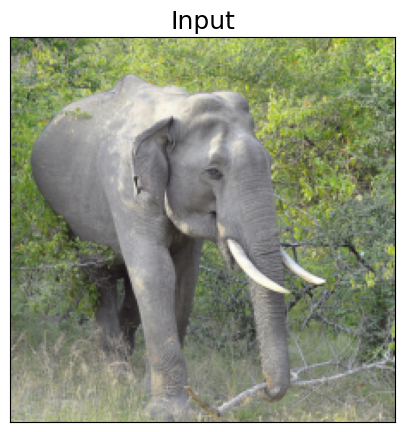

In [2]:
# image_path = "images/axolotl.JPEG" 
image_path = "images/elephant.JPEG" 

image = Image.open(image_path)
trans_img = transform(image)
input_tensor = normalize(trans_img).unsqueeze(0)

target_class = model_utils.getClass(input_tensor, model, device)
# open the class list so the detected class string can be returned for printing
with open('util/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
class_name = classes[target_class]
print(model_utils.getPrediction(input_tensor, model, device, target_class)[0] * 100, class_name)

# Show the image
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1, 1, figsize = (5, 5))
attr_to_subplot(trans_img, "Input", axs, original_image=True)
plt.show()
plt.close(fig)

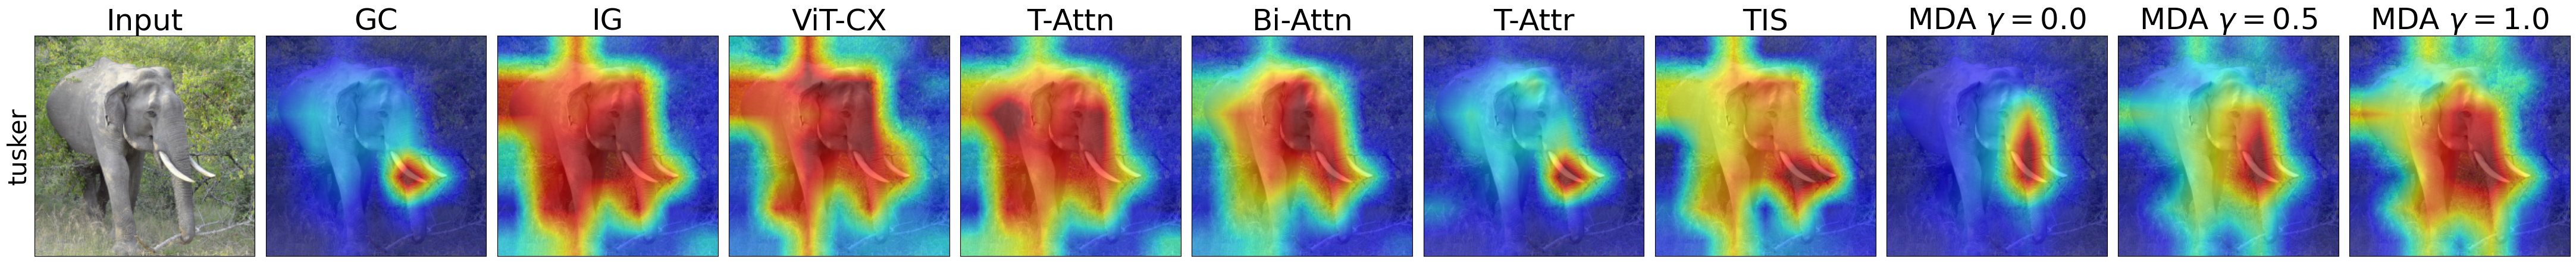

In [3]:
# initialize ins blur kernel
klen = 31
ksig = 31
kern = MAS.gkern(klen, ksig)
blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)

# Find minimum blur for model confidence < 1%
blur_perc = model_utils.getPrediction(blur(input_tensor), model, device, target_class)[0] * 100
while blur_perc > 1:
   klen += 4
   ksig += 4
   kern = MAS.gkern(klen, ksig)
   blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)
   blur_perc = model_utils.getPrediction(blur(input_tensor), model, device, target_class)[0] * 100
   
# generate Bi-Attn
bi_attn, map = explainer.bidirectional(input_tensor.to("cuda:0"), target_class)
bi_attn = resize(bi_attn.cpu().detach()).permute(1, 2, 0).cpu().numpy() * np.ones((224, 224, 3))

# Generate GC
gc = explainer.generate_cam_attn(input_tensor.to("cuda:0"), target_class)
gc = resize(gc.cpu().detach()).permute(1, 2, 0).cpu().numpy() * np.ones((224, 224, 3))

# Generate IG
states, ig, t_attn, cls, diag = explainer.generate_transition_attention_maps(input_tensor.to("cuda:0"), target_class, start_layer = 0)
t_attn = resize(t_attn.cpu().detach()).permute(1, 2, 0).cpu().numpy() * np.ones((224, 224, 3))
ig = resize(ig.cpu().detach()).permute(1, 2, 0).cpu().numpy() * np.ones((224, 224, 3))

# Generate T-Attr
T_attr = LRP_explainer.generate_LRP(input_tensor.cuda(), target_class, method="transformer_attribution", start_layer = 0)
T_attr = resize(T_attr.cpu().detach()).permute(1, 2, 0).cpu().numpy() * np.ones((224, 224, 3))

# Generate ViT_CX
target_layer = model.blocks[-1].norm1
result, features = ViT_CX(model, input_tensor, target_layer, gpu_batch=1, device = 'cuda:0')
vit_cx = (result.reshape((224, 224, 1)) * torch.ones((224, 224, 3))).cpu().detach().numpy()
vit_cx = (vit_cx - vit_cx.min()) / (vit_cx.max() - vit_cx.min())

# Generate TIS
saliency_method = TIS(model, batch_size=64)
saliency_map = saliency_method(input_tensor.cuda(), class_idx=target_class).cpu()
tis = resize(saliency_map.reshape((-1, saliency_map.shape[0], saliency_map.shape[1])).detach()).permute(1, 2, 0).cpu().numpy() * np.ones((224, 224, 3))

# Generate MDA
MGA_g_0, MGA_g_5, MGA_g_10 = MDAFunctions.MDA(trans_img, input_tensor.cpu(), bi_attn, num_patches ** 2, blur, model, device, img_hw, max_batch_size = 5)

plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 11, figsize = (55, 5))
attr_to_subplot(trans_img, "Input", axs[0], original_image = True)
axs[0].set_ylabel(class_name)
heatmap_overlap_axs(trans_img, gc, 'GC', axs[1])
heatmap_overlap_axs(trans_img, ig, 'IG', axs[2])
heatmap_overlap_axs(trans_img, vit_cx, 'ViT-CX', axs[3])
heatmap_overlap_axs(trans_img, t_attn, 'T-Attn', axs[4])
heatmap_overlap_axs(trans_img, bi_attn, 'Bi-Attn', axs[5])
heatmap_overlap_axs(trans_img, T_attr, 'T-Attr', axs[6])
heatmap_overlap_axs(trans_img, tis, 'TIS', axs[7])
heatmap_overlap_axs(trans_img, MGA_g_0, 'MDA $\\gamma = 0.0$', axs[8])
heatmap_overlap_axs(trans_img, MGA_g_5, 'MDA $\\gamma = 0.5$', axs[9])
heatmap_overlap_axs(trans_img, MGA_g_10, 'MDA $\\gamma = 1.0$', axs[10])
plt.subplots_adjust(wspace = 0.05)
plt.show()